In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
import time
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# assert(first_class_index in [0, 1])
first_class_index = 0


# There is one class, balloon, with ID n°0.

num_classes = 7

finetuned_classes = [
      "nothing", "bvm", "defib pads", "hands", "kelly", "syringe", "tourniquet"
]

# The `no_object` class will be automatically reserved by DETR with ID equal
# to `num_classes`, so ID n°1 here.  


print('First class index: {}'.format(first_class_index))  
print('Parameter num_classes: {}'.format(num_classes))
print('Fine-tuned classes: {}'.format(finetuned_classes))

import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_finetuned_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{finetuned_classes[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()


def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):
  
  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  print(probas_to_keep)
  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  
  return probas_to_keep, bboxes_scaled

def run_worflow(my_image, my_model):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(my_image).unsqueeze(0)

  # propagate through the model
  start_t = time.time()
  outputs = my_model(img)
  end_t = time.time()

  print("Inference time: ",end_t-start_t)
  for threshold in [0.7]:
    
    probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                              threshold=threshold)

    plot_finetuned_results(my_image,
                           probas_to_keep, 
                           bboxes_scaled)


/home/anonymous/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/sfs/qumulo/qhome/anonymous/.local/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


2.4.0+cu121 True
First class index: 0
Parameter num_classes: 7
Fine-tuned classes: ['nothing', 'bvm', 'defib pads', 'hands', 'kelly', 'syringe', 'tourniquet']


In [2]:
model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

# Load the saved weights into the model
checkpoint = torch.load('./weights/24_aug_6class.pth', map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=True)

model.eval();

Using cache found in /home/anonymous/.cache/torch/hub/facebookresearch_detr_main
/home/anonymous/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anonymous/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_572038/2001400438.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code durin

### Inference using images

(1920, 1080)
Inference time:  0.7165915966033936
tensor([[1.8044e-06, 2.1743e-03, 5.8764e-04, 9.5124e-01, 1.3282e-03, 2.7453e-03,
         7.0527e-04],
        [6.1338e-07, 3.6823e-04, 4.8223e-04, 9.9620e-01, 2.6791e-04, 6.3550e-04,
         3.7216e-04],
        [1.2416e-06, 4.8101e-04, 9.8205e-01, 8.9170e-03, 6.2343e-04, 3.5075e-04,
         1.1414e-03],
        [9.0366e-07, 4.8653e-04, 3.3406e-03, 9.7582e-01, 9.2574e-04, 1.7108e-03,
         3.4203e-04],
        [1.7385e-06, 9.6923e-01, 4.2346e-03, 1.2400e-02, 8.8372e-04, 2.0570e-03,
         1.0921e-03]])


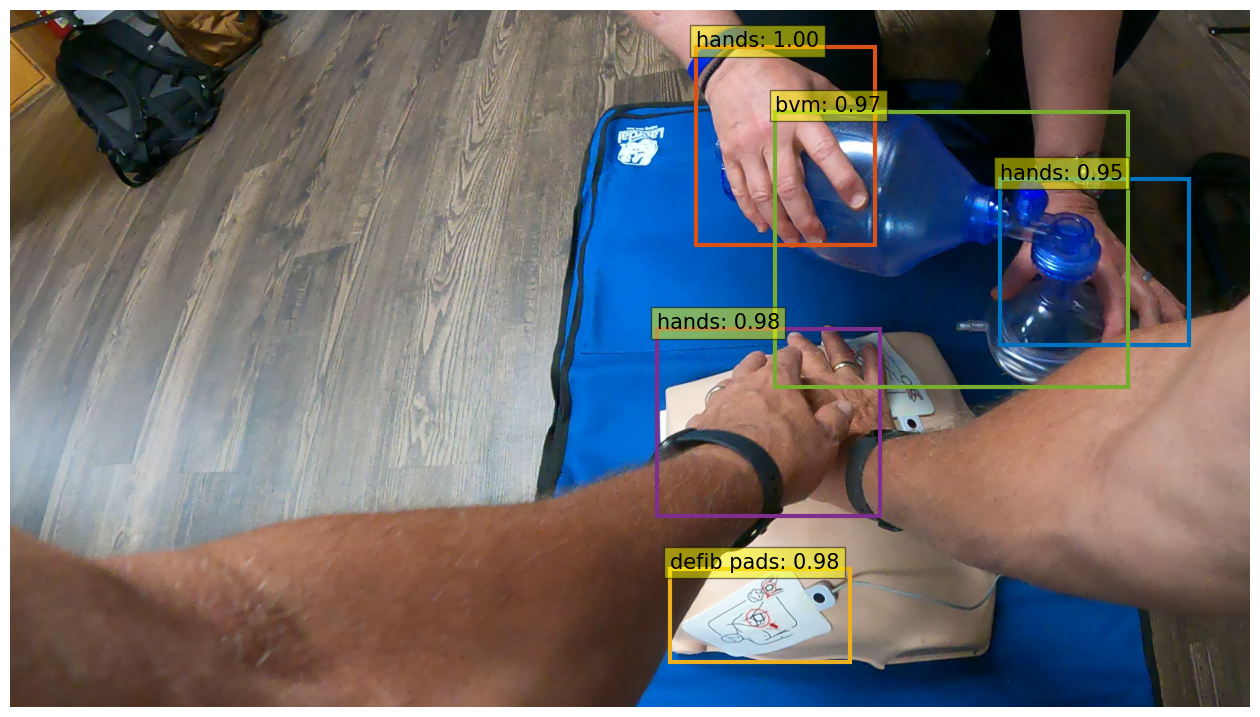

In [3]:
from PIL import Image

img_name = '/scratch/anonymous/compute/2024/repos/EMS-ActionNet/experimental/data/GX010308_frame_1200.jpg'
img_name = '/scratch/anonymous/compute/2024/repos/EMS-ActionNet/experimental/data/GX010308_frame_1650.jpg'
im = Image.open(img_name)

# print im size
print(im.size)
run_worflow(im,model)

## Inference for a video

In [7]:
import cv2
from PIL import Image
import os
import time
import json

# Define the video file path and output path
video_root_path = '/standard/storage/CognitiveEMS_Datasets/anonymous/Sep_2024/Raw/05-09-2024/anonymous/cardiac_arrest/0/GoPro/'

# iterate recursively over the video_root_path to get all video files
video_files = []
for root, dirs, files in os.walk(video_root_path):
    for file in files:
        if file.endswith('.mp4'):
            video_files.append(os.path.join(root, file))
        break

print(f'Found {len(video_files)} video files in the directory', video_files)




Found 1 video files in the directory ['/standard/storage/CognitiveEMS_Datasets/anonymous/Sep_2024/Raw/05-09-2024/anonymous/cardiac_arrest/0/GoPro/GX010321-encoded.mp4']


In [8]:

# Enable or disable saving annotated images
save_images = True

# Set the desired target FPS for downsampling
target_fps = 1  # You can adjust this value as needed

json_output_path = './outputs/bboxes/'

def generate_bboxes(video_files, model, json_output_path,  target_fps, save_images=False):

    for video_path in video_files:
        video_id = video_path.split('/')[-1].split('.')[0]
        img_output_path = f'./outputs/bboxes/{video_id}/'

        if not os.path.exists(json_output_path):
            os.makedirs(json_output_path)

        if save_images and not os.path.exists(img_output_path):
            os.makedirs(img_output_path)

        # Open the video file
        cap = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)

        # Get video properties
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        original_fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


        # Calculate the frame skipping rate
        skip_rate = original_fps // target_fps

        # Dictionary to store bounding boxes for each processed frame
        bbox_data = {video_id: []}

        # Convert RGB colors to BGR for OpenCV
        COLORS_BGR = [(int(c[2]*255), int(c[1]*255), int(c[0]*255)) for c in COLORS]

        print(f'Processing video: {video_id} with total frames: {total_frames}')
        # Process the video with frame skipping
        for i in range(total_frames):
            ret, frame = cap.read()
            if not ret:
                break

            # Only process frames at the specified interval (skip frames)
            if i % skip_rate != 0:
                continue

            # Convert the frame to a PIL image
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(frame_rgb)

            start_t = time.time()

            # Run inference on the current frame
            img = transform(pil_image).unsqueeze(0)
            outputs = model(img)
            end_t = time.time()

            probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs, threshold=0.7)

            # Save bounding boxes and class labels to the JSON data structure
            frame_bboxes = []
            for p, (xmin, ymin, xmax, ymax), c in zip(probas_to_keep, bboxes_scaled.tolist(), COLORS_BGR):
                cl = p.argmax()  # Class index
                class_label = finetuned_classes[cl]  # Get the corresponding class label
                confidence = p[cl].item()

                # Add bounding box info to the JSON dictionary
                frame_bboxes.append({
                    'class': class_label,
                    'confidence': confidence,
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax
                })

                # Annotate the frame
                cv2.rectangle(frame, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color=c, thickness=2)
                text = f'{class_label}: {confidence:.2f}'
                cv2.putText(frame, text, (int(xmin), int(ymin) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, c, 2)

            # Save the bounding box data for the current frame
            bbox_data[video_id].append({
                'frame': i,
                'bboxes': frame_bboxes
            })


            # Write the annotated frame to the output directory
            if save_images:
                cv2.imwrite(f'{img_output_path}/frame_{i}.jpg', frame)

            # Print progress for every processed frame
            print(f'Processed frame {i}/{total_frames} at downsampled rate (every {skip_rate}th frame)')
            print(f'Inference time for frame {i}: {end_t - start_t} seconds')


        # Save bounding box data to a JSON file
        with open(f'{json_output_path}/bboxes.json', 'w') as f:
            json.dump(bbox_data, f, indent=4)

        # Release resources when done
        cap.release()
        cv2.destroyAllWindows()

        print(f'Processed frames and bounding box data.')


In [9]:
generate_bboxes(video_files, model, json_output_path,  target_fps, save_images)


Processing video: GX010321-encoded with total frames: 4584
tensor([[2.0957e-05, 9.2176e-01, 4.5017e-02, 3.2146e-03, 2.5399e-03, 1.0074e-02,
         1.8255e-03]])
Processed frame 0/4584 at downsampled rate (every 29th frame)
Inference time for frame 0: 2.6742665767669678 seconds
tensor([[1.7318e-05, 9.4303e-01, 2.8054e-02, 2.7215e-03, 1.7017e-03, 8.4693e-03,
         1.4763e-03]])
Processed frame 29/4584 at downsampled rate (every 29th frame)
Inference time for frame 29: 0.88344407081604 seconds
tensor([[1.3144e-05, 9.5704e-01, 1.6964e-02, 1.8782e-03, 1.5560e-03, 7.6747e-03,
         1.3203e-03]])
Processed frame 58/4584 at downsampled rate (every 29th frame)
Inference time for frame 58: 0.7522768974304199 seconds
tensor([[1.3806e-05, 9.4872e-01, 2.3090e-02, 1.6344e-03, 1.7654e-03, 8.2335e-03,
         1.0677e-03]])
Processed frame 87/4584 at downsampled rate (every 29th frame)
Inference time for frame 87: 0.7857258319854736 seconds
tensor([[1.1496e-05, 9.5088e-01, 1.6339e-02, 2.4939e-

KeyboardInterrupt: 

In [10]:
import os

# Directory containing the images
directory = "/scratch/anonymous/compute/2024/repos/EgoExoEMS/Tools/ai_object_bbox_generation/detr/outputs/bboxes/GX010314_clipped_with_audio/original"

# List all files in the directory and sort them
files = sorted([f for f in os.listdir(directory) if f.endswith(".jpg")])

# Rename each file incrementing from 0000.jpg
for i, filename in enumerate(files):
    new_name = f"{i:04d}.jpg"  # Format the new name with zero-padding
    old_path = os.path.join(directory, filename)
    new_path = os.path.join(directory, new_name)
    
    # Renaming the file
    os.rename(old_path, new_path)
    print(f"Renamed {filename} to {new_name}")


Renamed 0000.jpg to 0000.jpg
Renamed 0029.jpg to 0001.jpg
Renamed 0058.jpg to 0002.jpg
Renamed 0087.jpg to 0003.jpg
Renamed 0116.jpg to 0004.jpg
Renamed 0145.jpg to 0005.jpg
Renamed 0174.jpg to 0006.jpg
Renamed 0203.jpg to 0007.jpg
Renamed 0232.jpg to 0008.jpg
Renamed 0261.jpg to 0009.jpg
Renamed 0290.jpg to 0010.jpg
Renamed 0319.jpg to 0011.jpg
Renamed 0348.jpg to 0012.jpg
Renamed 0377.jpg to 0013.jpg
Renamed 0406.jpg to 0014.jpg
Renamed 0435.jpg to 0015.jpg
Renamed 0464.jpg to 0016.jpg
Renamed 0493.jpg to 0017.jpg
Renamed 0522.jpg to 0018.jpg
Renamed 0551.jpg to 0019.jpg
Renamed 0580.jpg to 0020.jpg
Renamed 0609.jpg to 0021.jpg
Renamed 0638.jpg to 0022.jpg
Renamed 0667.jpg to 0023.jpg
Renamed 0696.jpg to 0024.jpg
Renamed 0725.jpg to 0025.jpg
Renamed 0754.jpg to 0026.jpg
Renamed 0783.jpg to 0027.jpg
Renamed 0812.jpg to 0028.jpg
Renamed 0841.jpg to 0029.jpg
Renamed 0870.jpg to 0030.jpg
Renamed 0899.jpg to 0031.jpg
Renamed 0928.jpg to 0032.jpg
Renamed 0957.jpg to 0033.jpg
Renamed 0986.j